In [39]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import pickle
import json
import requests

def get_num_tickets(val):
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    return sum(ticket_quant)
def get_num_tiers(val):
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    return len(ticket_quant)
def get_total_value(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    total = 0
    for cost, quant in zip(ticket_costs, ticket_quant):
        total += cost*quant
    return total
def get_max_ticket_cost(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    if len(ticket_costs) == 0:
        return 0
    else:
        return max(ticket_costs)
def get_min_ticket_cost(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    if len(ticket_costs) == 0:
        return 0
    else:
        return min(ticket_costs)
def clean_df(path_to_file):
    df=pd.read_json(path_to_file)
    df['tickets_total'] = df['ticket_types'].apply(get_num_tickets)
    df['tiers'] = df['ticket_types'].apply(get_num_tiers)
    df['max_cost'] = df['ticket_types'].apply(get_max_ticket_cost)
    df['min_cost'] = df['ticket_types'].apply(get_min_ticket_cost)
    df['total'] = df['ticket_types'].apply(get_total_value)
    df['intl_trans'] = df['country'] != df['venue_country']
    df['type_one_user'] = df['user_type'] == 1
    df['org_desc_exists'] = [0 if len(df['org_desc'][i])==0 else 1 for i in range(len(df))]
    df['org_name_exists'] = [0 if len(df['org_name'][i])==0 else 1 for i in range(len(df))]
    df['previous_payout_count'] = [len(df.previous_payouts[i]) for i in range(len(df))]
    df['org_facebook'].fillna(value=0, inplace=True)
    df['org_twitter'].fillna(value=0, inplace=True)
    df['org_facebook_exists'] = [0 if df['org_facebook'][i]==0 else 1 for i in range(len(df))]
    df['org_twitter_exists'] = [0 if df['org_twitter'][i]==0 else 1 for i in range(len(df))]
    emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
    df.loc[~df["email_domain"].isin(emaillist), "email_domain"] = 0
    df.loc[df["email_domain"].isin(emaillist), "email_domain"] = 1
    countrylist = ['MA','VN','A1','PK','PH','ID','NG','CI','CZ','DZ']
    df.loc[~df["country"].isin(countrylist), "country"] = 0
    df.loc[df["country"].isin(countrylist), "country"] = 1
    df.drop(['show_map','object_id', 'name','name_length','num_order','num_payouts','org_facebook','org_twitter','payee_name','payout_type','previous_payouts','previous_payouts','org_name','org_desc','listed','fb_published','event_published','event_end','event_start','event_created','has_logo','has_header','currency','description','approx_payout_date','delivery_method','body_length','channels','gts','sale_duration', 'sale_duration2', 'ticket_types', 'user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state'],axis=1,inplace=True)
    return df

def clean_new_data2(df):
    #df=pd.read_json(path_to_file)
    df['tickets_total'] = df['ticket_types'].apply(get_num_tickets)
    df['tiers'] = df['ticket_types'].apply(get_num_tiers)
    df['max_cost'] = df['ticket_types'].apply(get_max_ticket_cost)
    df['min_cost'] = df['ticket_types'].apply(get_min_ticket_cost)
    df['total'] = df['ticket_types'].apply(get_total_value)
    df['intl_trans'] = df['country'] != df['venue_country']
    df['type_one_user'] = df['user_type'] == 1
    df['org_desc_exists'] = [0 if len(df['org_desc'][i])==0 else 1 for i in range(len(df))]
    df['org_name_exists'] = [0 if len(df['org_name'][i])==0 else 1 for i in range(len(df))]
    df['previous_payout_count'] = [len(df.previous_payouts[i]) for i in range(len(df))]
    df['org_facebook'].fillna(value=0, inplace=True)
    df['org_twitter'].fillna(value=0, inplace=True)
    df['org_facebook_exists'] = [0 if df['org_facebook'][i]==0 else 1 for i in range(len(df))]
    df['org_twitter_exists'] = [0 if df['org_twitter'][i]==0 else 1 for i in range(len(df))]
    emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
    df.loc[~df["email_domain"].isin(emaillist), "email_domain"] = 0
    df.loc[df["email_domain"].isin(emaillist), "email_domain"] = 1
    countrylist = ['MA','VN','A1','PK','PH','ID','NG','CI','CZ','DZ']
    df.loc[~df["country"].isin(countrylist), "country"] = 0
    df.loc[df["country"].isin(countrylist), "country"] = 1
    df.drop(['object_id', 'name','name_length','num_order','num_payouts','org_facebook','org_twitter','payee_name','payout_type','previous_payouts','previous_payouts','org_name','org_desc','listed','fb_published','event_published','event_end','event_start','event_created','has_logo','has_header','currency','description','approx_payout_date','delivery_method','body_length','channels','gts','sale_duration', 'sale_duration2', 'ticket_types', 'user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state', 'show_map'],axis=1,inplace=True)
    return df

def get_page():
    """Revieves data from the specified url for prediction
    Returns: data (PandasDataFrame): 1 row DataFrame from url"""
    d = json.loads(requests.get('http://galvanize-case-study-on-fraud.herokuapp.com/data_point').text)
    data = pd.DataFrame(columns=list(d.keys()))
    data.loc[0] = list(d.values())
    return(data)

def predict_fraud(df, model):
    pred = model.predict(df)
    return pred[0]




#data frame used to train model
df = clean_df('../data/data.json')
df['fraud'] = df['acct_type'].str[0] == 'f'
df.drop('acct_type',axis=1,inplace=True)

In [49]:
df_test = get_page()

In [50]:
df_test = clean_new_data2(df_test)

In [51]:
predict_fraud(df_test,rf)

False

In [40]:
df

,country,email_domain,has_analytics,user_age,tickets_total,tiers,max_cost,min_cost,total,intl_trans,type_one_user,org_desc_exists,org_name_exists,previous_payout_count,org_facebook_exists,org_twitter_exists,fraud
0,0,0,0,36,920,3,550.00,25.00,36000.00,False,True,0,1,0,0,0,True
1,0,0,0,149,100,2,35.00,35.00,3500.00,False,False,1,1,49,0,1,False
2,0,0,0,214,48,1,93.51,93.51,4488.48,False,False,1,1,36,0,0,False
3,0,0,0,889,30000,6,25.00,5.00,410000.00,True,False,0,0,21,0,0,False
4,0,0,0,35,264,8,200.00,36.00,28596.00,False,False,1,1,49,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,0,0,0,400,1,45.00,45.00,18000.00,False,True,0,0,0,0,0,True
14333,0,0,0,1374,3256,8,90.00,0.00,187600.00,False,False,1,1,5,0,0,False
14334,0,0,0,84,148,5,150.00,5.00,3450.00,True,False,0,1,1,0,0,False
14335,0,0,0,812,100,2,79.33,79.33,7933.00,False,False,0,0,128,0,0,False


In [3]:

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

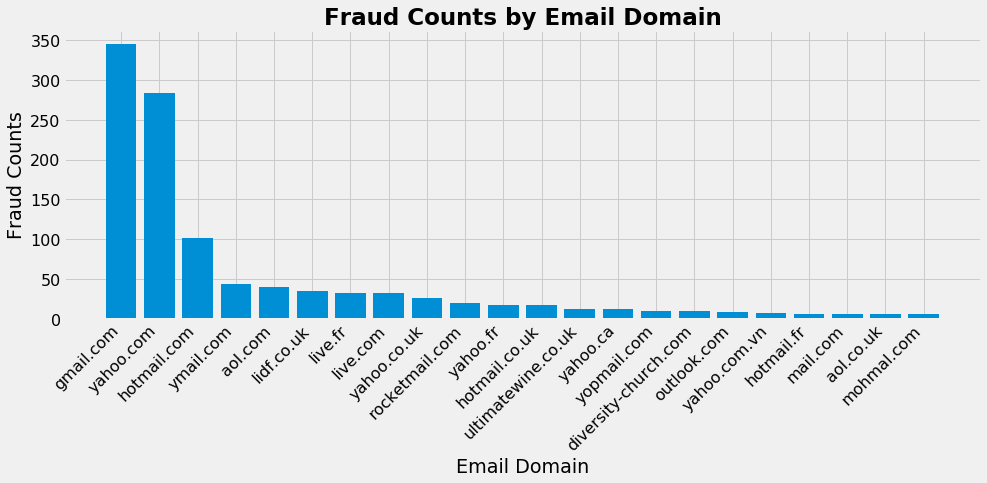

In [15]:
email = pd.concat([df['email_domain'],df['fraud']], axis=1, sort=False)
offenders = email[email['fraud']==True]['email_domain'].value_counts().rename_axis('email_domain').reset_index(name='counts')
offenders = offenders[offenders['counts']>5]
labels=offenders['email_domain']
fig, ax = plt.subplots(figsize=(14,7))
ax.bar(offenders['email_domain'],offenders['counts'])
ax.set_xlabel('Email Domain')
ax.set_ylabel('Fraud Counts')
ax.set_title('Fraud Counts by Email Domain',fontweight='bold')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.savefig('../images/fraud_email.png')

In [5]:
non_offenders = email[email['fraud']==False]['email_domain'].value_counts().rename_axis('email_domain').reset_index(name='counts')

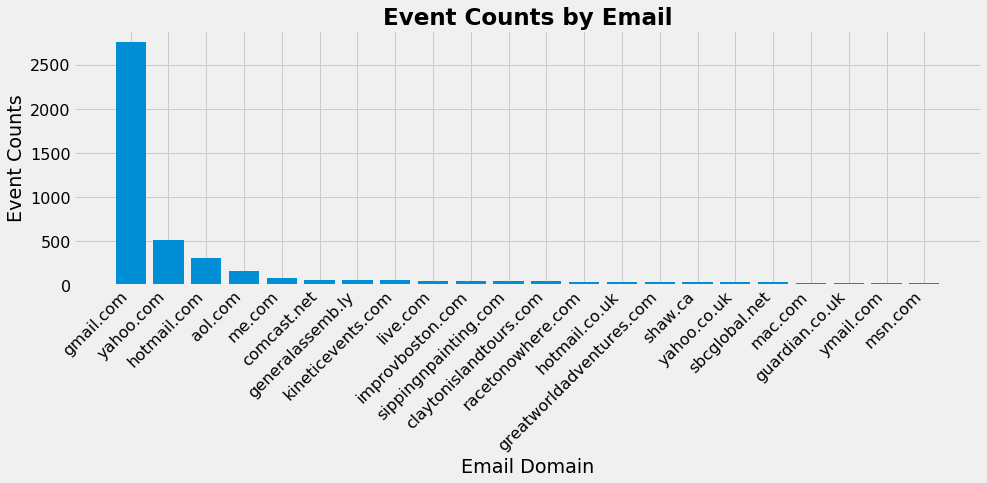

In [16]:
non_offenders = email[email['fraud']==False]['email_domain'].value_counts().rename_axis('email_domain').reset_index(name='counts')
non_offenders = non_offenders[:22]
labels=non_offenders['email_domain']
fig, ax = plt.subplots(figsize=(14,7))
ax.bar(non_offenders['email_domain'],non_offenders['counts'])
ax.set_xlabel('Email Domain')
ax.set_ylabel('Event Counts')
ax.set_title('Event Counts by Email',fontweight='bold')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.savefig('../images/event_email.png')

In [40]:
user_df = pd.concat([df['user_age'],df['fraud']], axis=1, sort=False)

In [41]:
user_df[user_df['user_age']==0]['fraud'].value_counts()

False    2020
True      725
Name: fraud, dtype: int64

In [42]:
df[df['country']=='US']['fraud'].value_counts()


Series([], Name: fraud, dtype: int64)

In [43]:
df[df['fraud']==True]['country'].value_counts()

0    1116
1     177
Name: country, dtype: int64

In [44]:
df['country']

0        0
1        0
2        0
3        0
4        0
        ..
14332    0
14333    0
14334    0
14335    0
14336    0
Name: country, Length: 14337, dtype: object

In [45]:
len(df)

14337

In [46]:
458/(1806+458)

0.20229681978798586

In [47]:
#Make plot
emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
email.loc[~email["email_domain"].isin(emaillist), "email_domain"] = "Other"
email['email_domain'].value_counts()

Other    14337
Name: email_domain, dtype: int64

In [80]:
df

,country,email_domain,has_analytics,user_age,tickets_total,tiers,max_cost,min_cost,total,intl_trans,type_one_user,org_desc_exists,org_name_exists,previous_payout_count,org_facebook_exists,org_twitter_exists,fraud
0,0,0,0,36,920,3,550.00,25.00,36000.00,False,True,0,1,0,0,0,True
1,0,0,0,149,100,2,35.00,35.00,3500.00,False,False,1,1,49,0,1,False
2,0,0,0,214,48,1,93.51,93.51,4488.48,False,False,1,1,36,0,0,False
3,0,0,0,889,30000,6,25.00,5.00,410000.00,True,False,0,0,21,0,0,False
4,0,0,0,35,264,8,200.00,36.00,28596.00,False,False,1,1,49,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,0,0,0,400,1,45.00,45.00,18000.00,False,True,0,0,0,0,0,True
14333,0,0,0,1374,3256,8,90.00,0.00,187600.00,False,False,1,1,5,0,0,False
14334,0,0,0,84,148,5,150.00,5.00,3450.00,True,False,0,1,1,0,0,False
14335,0,0,0,812,100,2,79.33,79.33,7933.00,False,False,0,0,128,0,0,False


In [37]:
X

,country,email_domain,has_analytics,user_age,tickets_total,tiers,max_cost,min_cost,total,intl_trans,type_one_user,org_desc_exists,org_name_exists,previous_payout_count,org_facebook_exists,org_twitter_exists
0,0,gmail.com,0,36,920,3,550.00,25.00,36000.00,False,True,0,1,0,0,0
1,0,ruf.org,0,149,100,2,35.00,35.00,3500.00,False,False,1,1,49,0,1
2,0,pvsd.k12.ca.us,0,214,48,1,93.51,93.51,4488.48,False,False,1,1,36,0,0
3,0,irishtabletennis.com,0,889,30000,6,25.00,5.00,410000.00,True,False,0,0,21,0,0
4,0,artsandbusinesscouncil.org,0,35,264,8,200.00,36.00,28596.00,False,False,1,1,49,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,yahoo.com,0,0,400,1,45.00,45.00,18000.00,False,True,0,0,0,0,0
14333,0,me.com,0,1374,3256,8,90.00,0.00,187600.00,False,False,1,1,5,0,0
14334,0,yahoo.com,0,84,148,5,150.00,5.00,3450.00,True,False,0,1,1,0,0
14335,0,velvetlist.com,0,812,100,2,79.33,79.33,7933.00,False,False,0,0,128,0,0


In [41]:
X=df.drop('fraud',axis=1)
y=df['fraud']

In [42]:
rf = RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [43]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
def eval_model(model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print('===ACCURACY===')
    print(acc)
    print('===RECALL===')
    print(rec)
    print('===PRECISION===')
    print(prec)
    print('===F1===')
    print(f1)

In [45]:
eval_model(rf,X_test,y_test)

===ACCURACY===
0.9866108786610879
===RECALL===
0.8947368421052632
===PRECISION===
0.9537953795379538
===F1===
0.9233226837060703


In [66]:

import requests
page = requests.get('http://galvanize-case-study-on-fraud.herokuapp.com/data_point')


In [67]:
x =json.loads(page.content)

In [82]:
import requests
def get_page():
    """Revieves data from the specified url for prediction
    Returns: data (PandasDataFrame): 1 row DataFrame from url"""
    d = json.loads(requests.get('http://galvanize-case-study-on-fraud.herokuapp.com/data_point').text)
    data = pd.DataFrame(columns=list(d.keys()))
    data.loc[0] = list(d.values())
    return(data)

In [138]:
df_test = get_page()

In [139]:
df_test['description']==df_test2['description']

0    True
Name: description, dtype: bool

In [88]:
def get_page():
    """Revieves data from the specified url for prediction
    Returns: data (PandasDataFrame): 1 row DataFrame from url"""
    d = json.loads(requests.get('http://galvanize-case-study-on-fraud.herokuapp.com/data_point').text)
    data = pd.DataFrame(columns=list(d.keys()))
    data.loc[0] = list(d.values())
    return(data)
def clean_new_data2(df):
    #df=pd.read_json(path_to_file)
    df['tickets_total'] = df['ticket_types'].apply(get_num_tickets)
    df['tiers'] = df['ticket_types'].apply(get_num_tiers)
    df['max_cost'] = df['ticket_types'].apply(get_max_ticket_cost)
    df['min_cost'] = df['ticket_types'].apply(get_min_ticket_cost)
    df['total'] = df['ticket_types'].apply(get_total_value)
    df['intl_trans'] = df['country'] != df['venue_country']
    df['type_one_user'] = df['user_type'] == 1
    df['org_desc_exists'] = [0 if len(df['org_desc'][i])==0 else 1 for i in range(len(df))]
    df['org_name_exists'] = [0 if len(df['org_name'][i])==0 else 1 for i in range(len(df))]
    df['previous_payout_count'] = [len(df.previous_payouts[i]) for i in range(len(df))]
    df['org_facebook'].fillna(value=0, inplace=True)
    df['org_twitter'].fillna(value=0, inplace=True)
    df['org_facebook_exists'] = [0 if df['org_facebook'][i]==0 else 1 for i in range(len(df))]
    df['org_twitter_exists'] = [0 if df['org_twitter'][i]==0 else 1 for i in range(len(df))]
    emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
    df.loc[~df["email_domain"].isin(emaillist), "email_domain"] = 0
    df.loc[df["email_domain"].isin(emaillist), "email_domain"] = 1
    countrylist = ['MA','VN','A1','PK','PH','ID','NG','CI','CZ','DZ']
    df.loc[~df["country"].isin(countrylist), "country"] = 0
    df.loc[df["country"].isin(countrylist), "country"] = 1
    df.drop(['object_id', 'name','name_length','num_order','num_payouts','org_facebook','org_twitter','payee_name','payout_type','previous_payouts','previous_payouts','org_name','org_desc','listed','fb_published','event_published','event_end','event_start','event_created','has_logo','has_header','currency','description','approx_payout_date','delivery_method','body_length','channels','gts','sale_duration', 'sale_duration2', 'ticket_types', 'user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state', 'show_map'],axis=1,inplace=True)
    return df

In [89]:
clean_new_data2(df_test)

,country,email_domain,has_analytics,user_age,tickets_total,tiers,max_cost,min_cost,total,intl_trans,type_one_user,org_desc_exists,org_name_exists,previous_payout_count,org_facebook_exists,org_twitter_exists
0,0,0,0,371,129,6,500.0,0.0,3850.0,False,False,0,1,1,1,0


In [106]:
start

1590775103.158088

In [107]:
end = time.time()

In [128]:
import threading 
def ping_site():
    
    
timer = threading.Timer(6.0, ping_site) 
timer.start()


In [129]:
timer = threading.Timer(6.0, ping_site) 

In [131]:
timer.start()

opk


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence
from joblib import dump, load
import pickle
import matplotlib.pyplot as plt

def get_feature_importances(model, X_train):
    for i in range(0, len(X_train.columns)):
        print(str(X_train.columns[i]) + ': ' + str(rf_model.feature_importances_[i]))
        
def eval_model(model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print('===ACCURACY===')
    print(acc)
    print('===RECALL===')
    print(rec)
    print('===PRECISION===')
    print(prec)
    print('===F1===')
    print(f1)


if __name__ == '__main__':
    df = pd.read_pickle('../data/pickled_df.pkl')

    y = df['fraud']
    X = df.drop('fraud', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
    rf_model.fit(X_train,y_train)
    eval_model(rf_model, X_test, y_test)
    probs = rf_model.predict_proba(X_test)

    get_feature_importances(rf_model, X_train)

    pkl_filename = "../data/rf_taylor_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(rf_model, file)

===ACCURACY===
0.9860524091293322
===RECALL===
0.8875878220140515
===PRECISION===
0.9546599496221663
===F1===
0.9199029126213593
country: 0.03291365184242867
email_domain: 0.02815465070523397
has_analytics: 0.0011956894798488577
user_age: 0.07040939398723803
tickets_total: 0.04591173541151987
tiers: 0.025795253977855568
max_cost: 0.05008190762408819
min_cost: 0.045203647298033306
total: 0.0574694373463056
intl_trans: 0.016670486154964664
type_one_user: 0.03856611023918366
org_desc_exists: 0.009772607463007992
org_name_exists: 0.017613215566258132
previous_payout_count: 0.5392626194100607
org_facebook_exists: 0.01406014835729142
org_twitter_exists: 0.006919445136681476


In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import pickle
import json
import requests

def get_num_tickets(val):
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    return sum(ticket_quant)
def get_num_tiers(val):
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    return len(ticket_quant)
def get_total_value(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    total = 0
    for cost, quant in zip(ticket_costs, ticket_quant):
        total += cost*quant
    return total
def get_max_ticket_cost(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    if len(ticket_costs) == 0:
        return 0
    else:
        return max(ticket_costs)
def get_min_ticket_cost(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    if len(ticket_costs) == 0:
        return 0
    else:
        return min(ticket_costs)
def clean_df(path_to_file):
    df=pd.read_json(path_to_file)
    df['tickets_total'] = df['ticket_types'].apply(get_num_tickets)
    df['tiers'] = df['ticket_types'].apply(get_num_tiers)
    df['max_cost'] = df['ticket_types'].apply(get_max_ticket_cost)
    df['min_cost'] = df['ticket_types'].apply(get_min_ticket_cost)
    df['total'] = df['ticket_types'].apply(get_total_value)
    df['intl_trans'] = df['country'] != df['venue_country']
    df['type_one_user'] = df['user_type'] == 1
    df['org_desc_exists'] = [0 if len(df['org_desc'][i])==0 else 1 for i in range(len(df))]
    df['org_name_exists'] = [0 if len(df['org_name'][i])==0 else 1 for i in range(len(df))]
    df['previous_payout_count'] = [len(df.previous_payouts[i]) for i in range(len(df))]
    df['org_facebook'].fillna(value=0, inplace=True)
    df['org_twitter'].fillna(value=0, inplace=True)
    df['org_facebook_exists'] = [0 if df['org_facebook'][i]==0 else 1 for i in range(len(df))]
    df['org_twitter_exists'] = [0 if df['org_twitter'][i]==0 else 1 for i in range(len(df))]
    emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
    df.loc[~df["email_domain"].isin(emaillist), "email_domain"] = 0
    df.loc[df["email_domain"].isin(emaillist), "email_domain"] = 1
    countrylist = ['MA','VN','A1','PK','PH','ID','NG','CI','CZ','DZ']
    df.loc[~df["country"].isin(countrylist), "country"] = 0
    df.loc[df["country"].isin(countrylist), "country"] = 1
    df.drop(['show_map','object_id', 'name','name_length','num_order','num_payouts','org_facebook','org_twitter','payee_name','payout_type','previous_payouts','previous_payouts','org_name','org_desc','listed','fb_published','event_published','event_end','event_start','event_created','has_logo','has_header','currency','description','approx_payout_date','delivery_method','body_length','channels','gts','sale_duration', 'sale_duration2', 'ticket_types', 'user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state'],axis=1,inplace=True)
    return df

def clean_new_data2(df):
    #df=pd.read_json(path_to_file)
    df['tickets_total'] = df['ticket_types'].apply(get_num_tickets)
    df['tiers'] = df['ticket_types'].apply(get_num_tiers)
    df['max_cost'] = df['ticket_types'].apply(get_max_ticket_cost)
    df['min_cost'] = df['ticket_types'].apply(get_min_ticket_cost)
    df['total'] = df['ticket_types'].apply(get_total_value)
    df['intl_trans'] = df['country'] != df['venue_country']
    df['type_one_user'] = df['user_type'] == 1
    df['org_desc_exists'] = [0 if len(df['org_desc'][i])==0 else 1 for i in range(len(df))]
    df['org_name_exists'] = [0 if len(df['org_name'][i])==0 else 1 for i in range(len(df))]
    df['previous_payout_count'] = [len(df.previous_payouts[i]) for i in range(len(df))]
    df['org_facebook'].fillna(value=0, inplace=True)
    df['org_twitter'].fillna(value=0, inplace=True)
    df['org_facebook_exists'] = [0 if df['org_facebook'][i]==0 else 1 for i in range(len(df))]
    df['org_twitter_exists'] = [0 if df['org_twitter'][i]==0 else 1 for i in range(len(df))]
    emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
    df.loc[~df["email_domain"].isin(emaillist), "email_domain"] = 0
    df.loc[df["email_domain"].isin(emaillist), "email_domain"] = 1
    countrylist = ['MA','VN','A1','PK','PH','ID','NG','CI','CZ','DZ']
    df.loc[~df["country"].isin(countrylist), "country"] = 0
    df.loc[df["country"].isin(countrylist), "country"] = 1
    df.drop(['object_id', 'name','name_length','num_order','num_payouts','org_facebook','org_twitter','payee_name','payout_type','previous_payouts','previous_payouts','org_name','org_desc','listed','fb_published','event_published','event_end','event_start','event_created','has_logo','has_header','currency','description','approx_payout_date','delivery_method','body_length','channels','gts','sale_duration', 'sale_duration2', 'ticket_types', 'user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state', 'show_map'],axis=1,inplace=True)
    return df

def get_page():
    """Revieves data from the specified url for prediction
    Returns: data (PandasDataFrame): 1 row DataFrame from url"""
    d = json.loads(requests.get('http://galvanize-case-study-on-fraud.herokuapp.com/data_point').text)
    data = pd.DataFrame(columns=list(d.keys()))
    data.loc[0] = list(d.values())
    return(data)

def predict_fraud(df, model):
    pred = model.predict(df)
    return pred[0]

if __name__ == '__main__':

    pkl_filename = "../data/rf_taylor_model.pkl"

    with open(pkl_filename, 'rb') as file:
        model = pickle.load(file)

    df_new = get_page()
    df_new = clean_new_data2(df_new)

    print(predict_fraud(df_new, model))

    prediction, event = (predict_fraud(df_new, model)), df_new

True


In [41]:
def probability(df):
    x = model.predict_proba(df_new)[0][1]
    if x < .33:
        return 'Low Risk'
    elif x < .66:
        return 'Medium Risk'
    else:
        return 'High Risk'
        
probability(df_new)

'High Risk'

In [42]:
x = model.predict_proba(df_new)[0][1]

In [43]:
probability(df_new)

'High Risk'

In [40]:
event

,country,email_domain,has_analytics,user_age,tickets_total,tiers,max_cost,min_cost,total,intl_trans,type_one_user,org_desc_exists,org_name_exists,previous_payout_count,org_facebook_exists,org_twitter_exists
0,0,0,0,0,0,0,0,0,0,True,True,1,1,0,0,0
